<center>
<b>EC4.403: Robotics: Planning and Navigation</b> <br>
<b>Spring 2021</b> <br>
<b>Assignment-1 </b>
</center>

<div style="text-align: right"><b>Team:</b> Makkhi-2 (2018102023, 2018111003)</div>

# Import Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import os
import shutil

# Helper Functions - To help create occupancy grid

In [2]:
def addRectangle(image,x0,y0,height,width):
    '''Function to add rectangular obstacles to our world. Note that (0,0) corresponds to the top left corner
    of the image'''
    image[y0:y0+height,x0:x0+width,:]=0
    return image

def addCircle(image,center_x, center_y,radius,colour=(0,0,0),thickness=-1):
    '''Function to add circular obstacles to our world. Note that (0,0) corresponds to the top left corner
    of the image'''
    return cv2.circle(image,(center_x,center_y),radius,colour,thickness)

def addBorders(world,border_thickness=5):
    world[:,:border_thickness,:]=0 # Left border
    world[:border_thickness,:,:]=0 # Top border
    world[:,-border_thickness:,:]=0 # Right border
    world[-border_thickness:,:,:]=0 # Bottom border
    return world

def createWorld(height,width,start_point,goal_point):
    '''Function to make the world/occupancy grid.'''
    # Create an empty space of size heightxwidth
    world=np.uint8(np.full((height,width,3),255))
    
    # Add borders to our empty space
    world=addBorders(world)

    # Add rectangular obstacles to the world
    world=addRectangle(world,x0=25,y0=150,height=150,width=40)
    world=addRectangle(world,x0=250,y0=100,height=50,width=10)
    world=addRectangle(world,x0=250,y0=250,height=10,width=50)
    world=addRectangle(world,x0=100,y0=50,height=10,width=150)
    world=addRectangle(world,x0=50,y0=0,height=50,width=10)
    
    # Add circular obstacles to the world    
    world=addCircle(center_x=150,center_y=150,radius=50,image=world)
    
    # Mark start and end points on the world
    world=addCircle(image=world,center_x=start_point[0],center_y=start_point[1],\
                    radius=5,colour=(0,0,255),thickness=-1) #Draw a blue circle representing start
    world=addCircle(image=world,center_x=goal_point[0],center_y=goal_point[1],\
                    radius=5,colour=(0,255,0),thickness=-1) #Draw a green circle representing goal

    '''The empty spaces in the world correspond to the points where world[i][j]=255 and obstacles correspond to 
    places where world[i][j]=0'''    
    
    return world

def obstacleCount(world):
    return (world == [0, 0, 0]).all(axis = 2).sum()
def getFreeSpaces(world):
    return np.array(np.where((world == [255, 255, 255]).all(axis = 2))).T 

# RRT Function Definition

In [3]:
def rrt(start_point,goal_point,world,step_length=10, threshold=5):
    
    obstacle_count=obstacleCount(world)
    free_spaces = getFreeSpaces(world) # obstacle free_spaces space
    tree = []
    tree.append(list(start_point))
    tree=np.array(tree)
    output_path='./results/holonomic/frames/'
    shutil.rmtree(output_path)
    os.mkdir(output_path)
    frame_count=0
    while True:
        rdm_idx=np.random.randint(len(free_spaces))
        x_k=free_spaces[rdm_idx]
        closest_index=distance.cdist([x_k], tree).argmin()

        x_n=tree[closest_index]
        x_s=x_n + step_length*(x_k-x_n)/np.linalg.norm(x_k-x_n)
        x_s=x_s.astype(np.int)

        if not x_s in free_spaces:
            continue
        
        world_copy = np.copy(world)
        world_copy = cv2.line(world_copy, tuple(x_n)[::-1], tuple(x_s)[::-1], (0, 0, 255), 1)
        obstacle_count_new=obstacleCount(world_copy)

        if obstacle_count_new != obstacle_count:
            continue # collision occurred; Skip this iteration

        world = world_copy
        tree = np.array(np.where((world == [0, 0, 255]).all(axis = 2))).T
        free_spaces = getFreeSpaces(world)
        frame_count+=1
        frame_save_location=output_path + str(frame_count) + ".jpg"
        cv2.imwrite(frame_save_location,world)

        plt.imshow(world)
        plt.show()
        if len(free_spaces)<=0:
            break  # If no more free spaces remaining, break

        goal_distance = distance.cdist([goal_point], tree)
        closest_index = goal_distance.argmin()
        if goal_distance[0, closest_index] <= threshold:
            goal_point = tree[closest_index]
            break # If within acceptable distance of goal, break

# Main

Below is an image of our world.
Blue dot represents start node,
Green dot represents goal node,
Black regions represent obstacles
White regions represent empty spaces



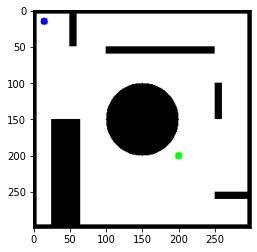

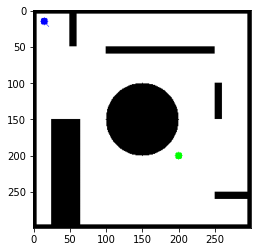

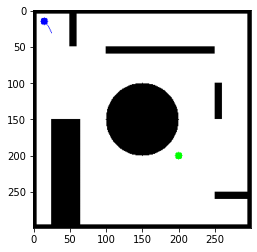

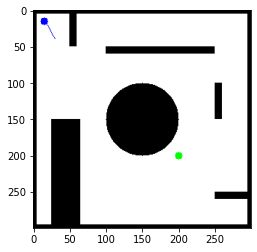

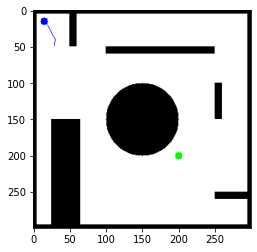

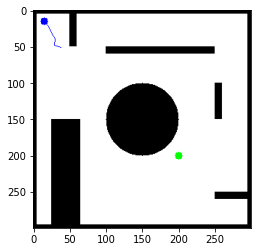

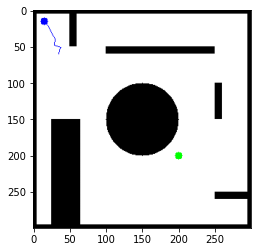

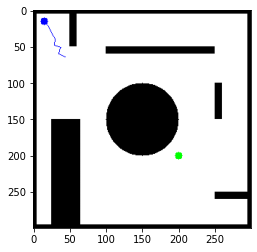

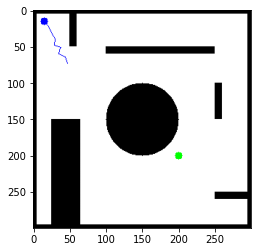

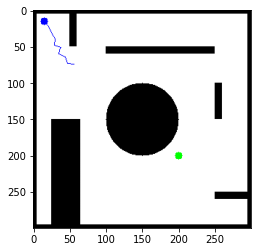

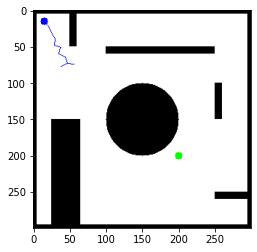

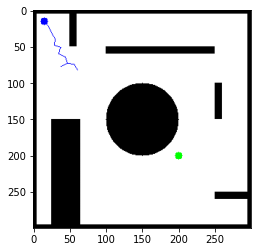

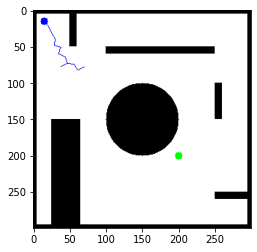

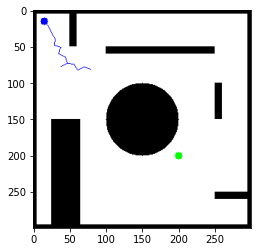

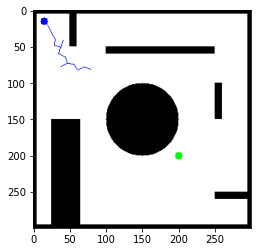

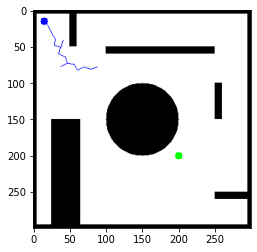

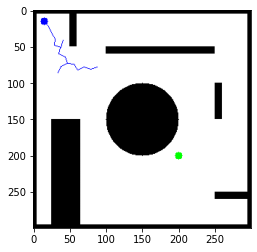

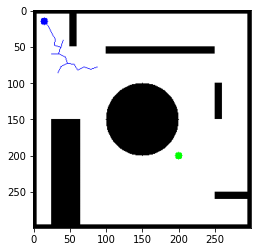

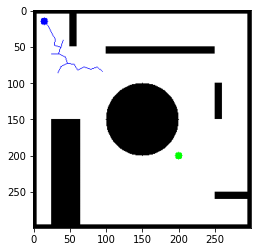

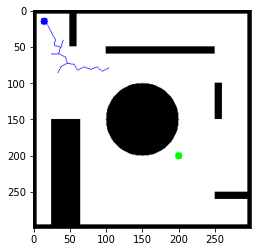

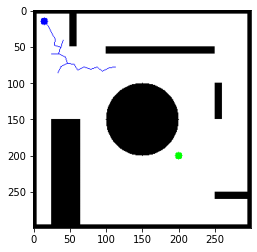

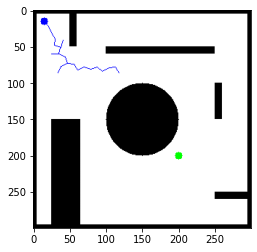

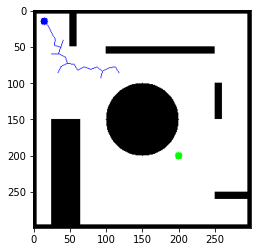

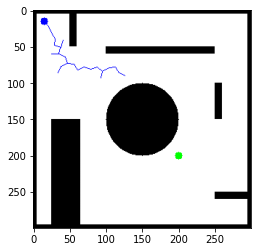

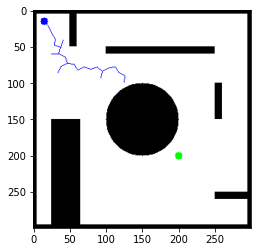

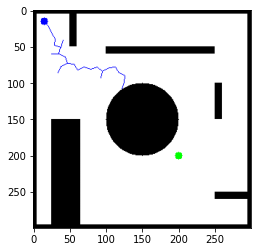

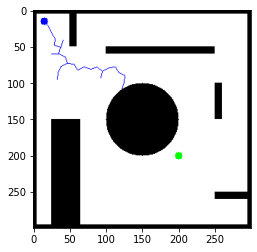

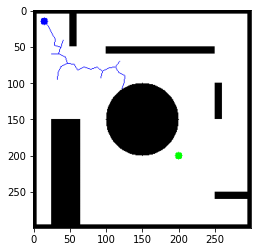

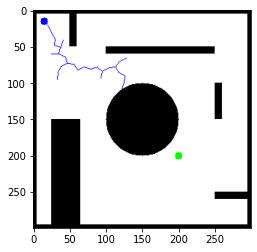

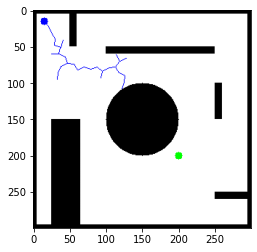

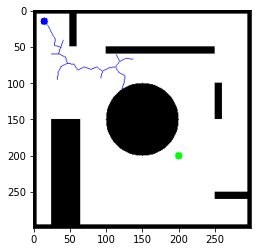

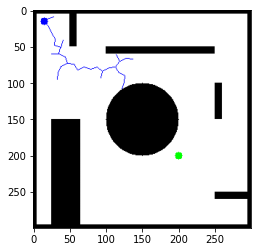

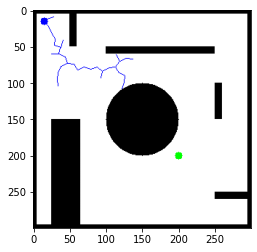

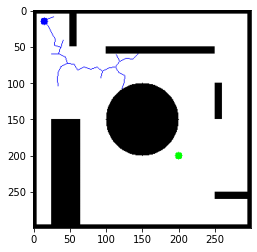

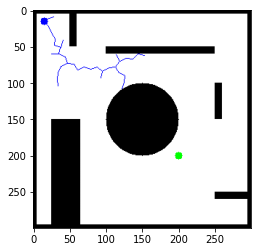

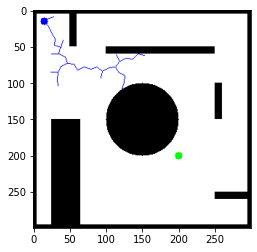

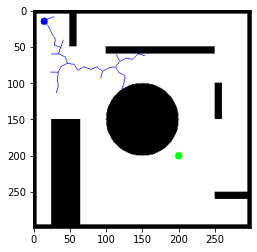

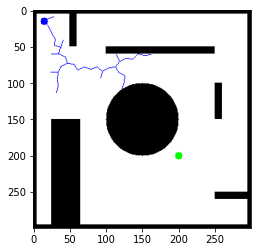

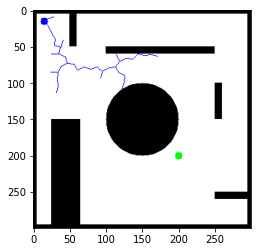

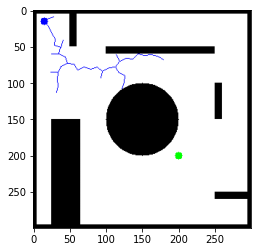

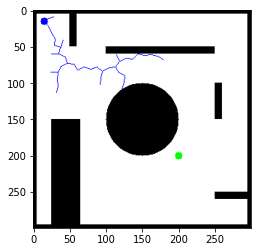

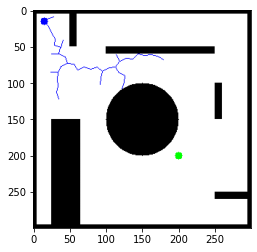

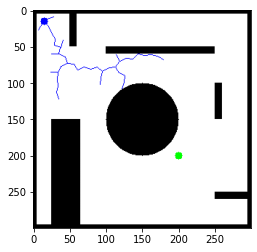

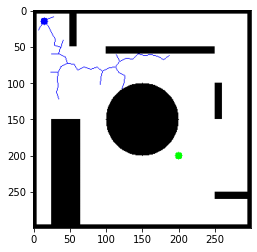

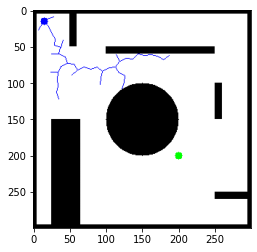

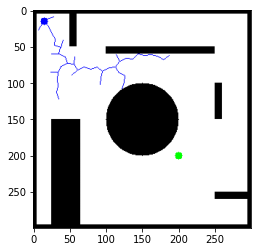

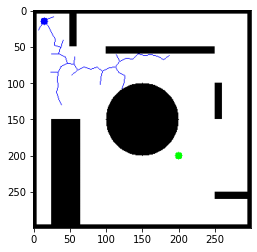

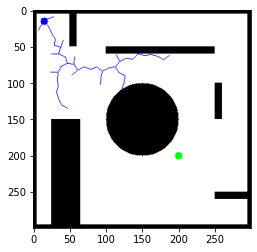

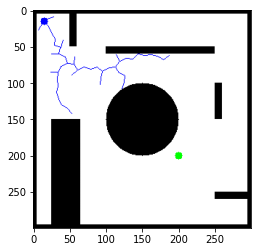

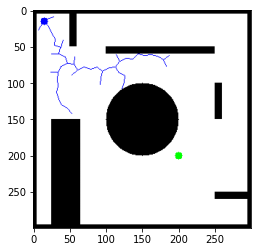

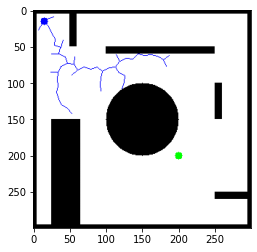

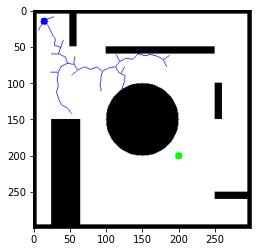

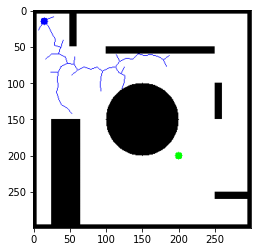

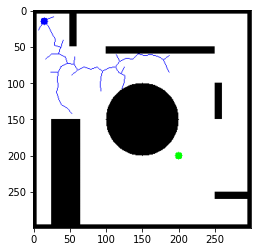

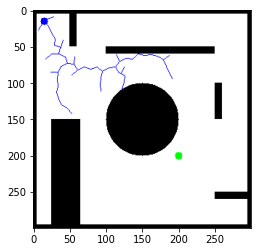

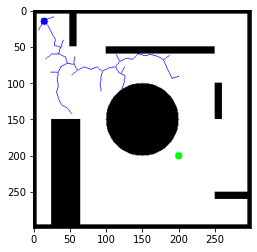

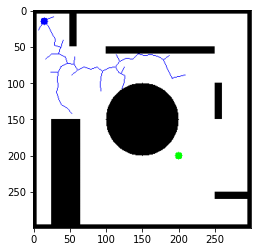

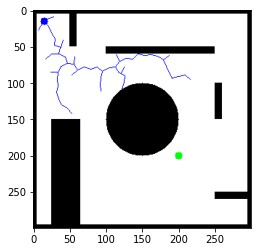

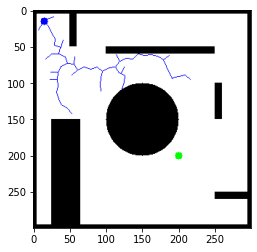

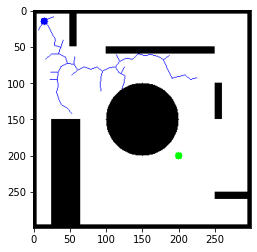

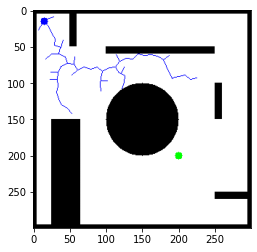

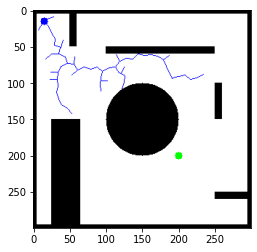

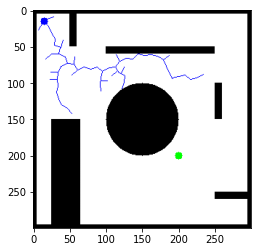

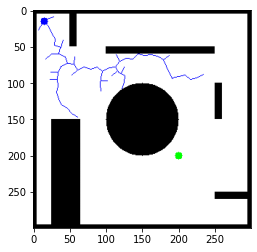

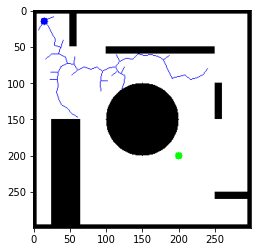

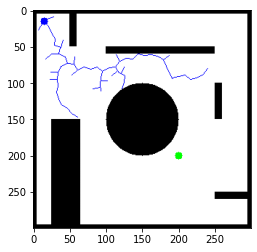

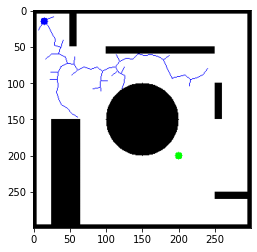

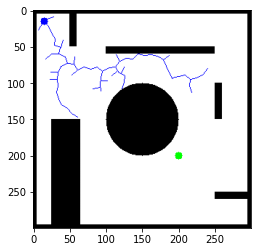

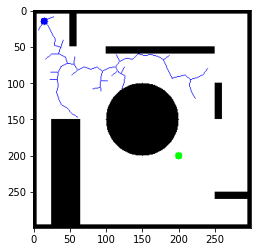

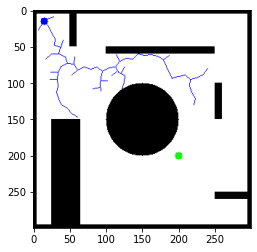

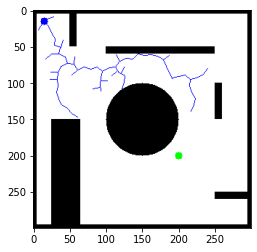

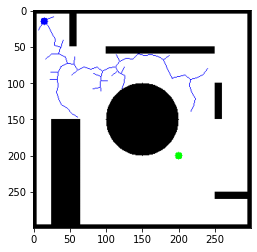

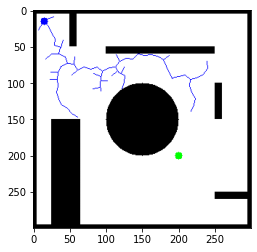

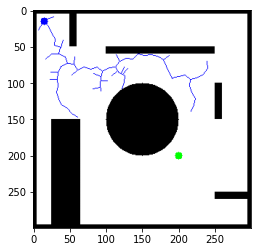

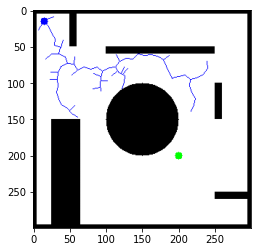

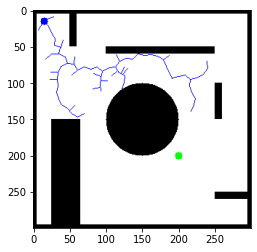

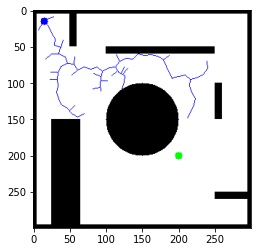

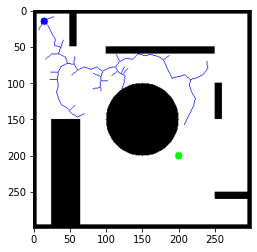

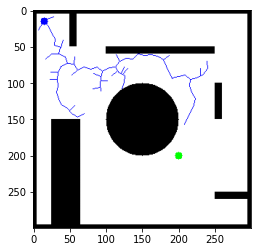

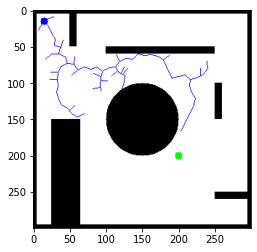

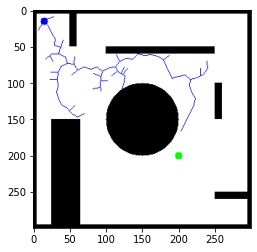

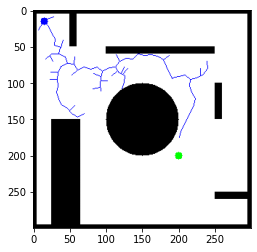

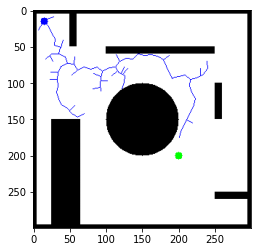

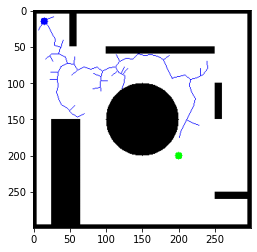

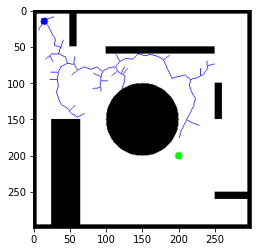

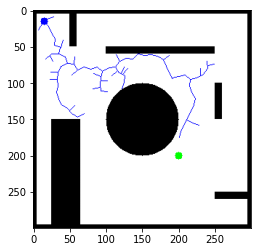

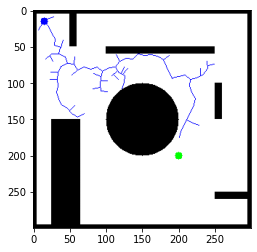

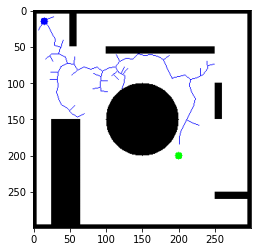

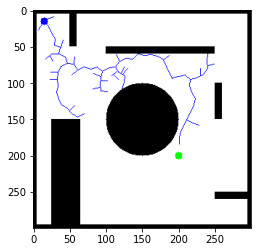

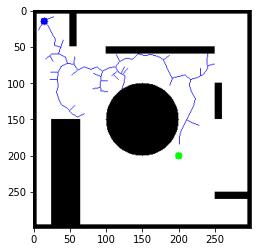

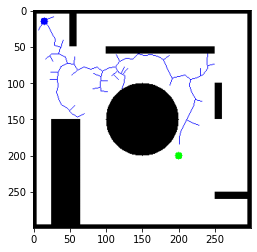

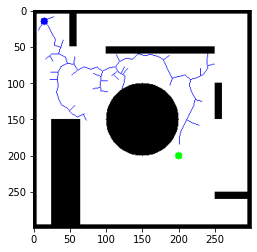

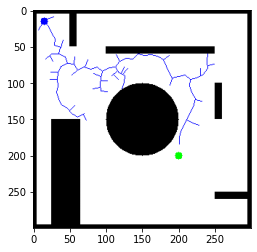

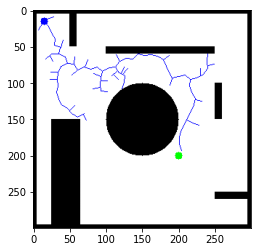

In [4]:
# Define start and end nodes
start_point=(15,15)
goal_point=(200,200)

# Initialize and display world
world=createWorld(300,300,start_point,goal_point)
print("Below is an image of our  world.\nBlue dot represents start node,\nGreen dot represents goal node,\n\
Black regions represent obstacles\nWhite regions represent empty spaces\n")
plt.imshow(world) # Visualize how are world looks like
plt.show()

# Call RRT
rrt(start_point,goal_point,world,threshold=10,step_length=10)